# Volatility Estimation with Microstructure Noise

This notebook runs the full analysis for the project:
- Signature plot (RV vs sampling frequency)
- Monte Carlo comparison (MSE vs frequency) for RV / subsampled RV / TSRV

The core logic lives in `src/`. This notebook just runs it and visualises results.


In [8]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from src.experiments import (
    run_signature_experiment,
    plot_signature,
    run_monte_carlo_experiment,
    plot_mse,
)


## Parameters

- `T`: length of the interval (set to 1 for simplicity)
- `sigma`: volatility of the efficient price process
- `eta`: microstructure noise standard deviation
- `base_n`: high-frequency grid size used for the signature plot


In [10]:
T = 1.0
sigma = 0.2
eta = 0.001
seed = 42

base_n = 39_000
sampling_steps = [1, 5, 10, 30, 60, 300, 600]


## Signature Plot

This compares realised variance computed from:
- the **efficient** (noise-free) log-price
- the **observed** (noisy) log-price

As sampling frequency increases, RV on observed prices should increase due to noise.


In [11]:
df_signature = run_signature_experiment(
    T=T,
    sigma=sigma,
    eta=eta,
    base_n=base_n,
    sampling_steps=sampling_steps,
    seed=seed,
)

df_signature


,k,effective_n,rv_efficient,rv_observed
0,1,39000,0.039576,0.117829
1,5,7800,0.040395,0.054855
2,10,3900,0.039256,0.045711
3,30,1300,0.040961,0.043152
4,60,650,0.040535,0.041762
5,300,130,0.036524,0.036927
6,600,65,0.040279,0.041575


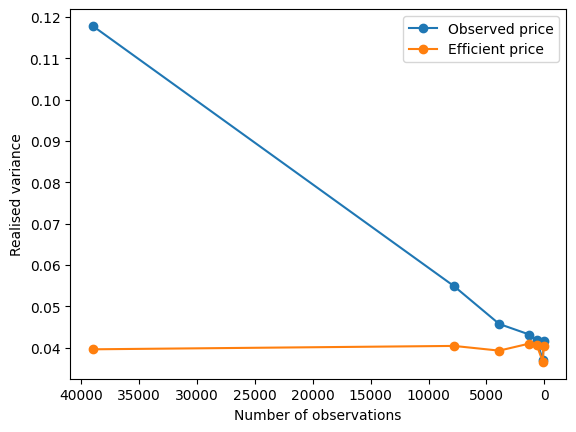

In [12]:
plt.figure()
plt.plot(df_signature["effective_n"], df_signature["rv_observed"], marker="o", label="Observed price")
plt.plot(df_signature["effective_n"], df_signature["rv_efficient"], marker="o", label="Efficient price")
plt.xlabel("Number of observations")
plt.ylabel("Realised variance")
plt.legend()
plt.gca().invert_xaxis()
plt.show()


In [13]:
from pathlib import Path

Path("figures").mkdir(parents=True, exist_ok=True)


In [14]:
plot_signature(df_signature, "figures/signature_plot.png")
print("Saved: figures/signature_plot.png")


Saved: figures/signature_plot.png


## Monte Carlo Comparison (MSE vs Sampling Frequency)

For each sampling frequency `n`, this simulates many price paths and estimates integrated variance using:
- RV
- Subsampled RV
- TSRV

We compare estimators using bias, variance, and mean squared error (MSE).


In [15]:
n_list = [390, 3_900, 39_000]
n_sims = 500

df_mc = run_monte_carlo_experiment(
    T=T,
    sigma=sigma,
    eta=eta,
    n_list=n_list,
    n_sims=n_sims,
    seed=seed,
)

df_mc


,n,estimator,bias,variance,mse
0,390,RV,0.000631,9.627548e-06,0.000010
1,390,Subsampled RV,0.000084,4.006648e-05,0.000040
2,390,TSRV,-0.001791,1.051701e-04,0.000108
3,3900,RV,0.007812,1.236048e-06,0.000062
4,3900,Subsampled RV,0.001538,4.865044e-06,0.000007
5,3900,TSRV,-0.000810,3.842766e-05,0.000039
6,39000,RV,0.078015,8.255760e-07,0.006087
7,39000,Subsampled RV,0.015572,8.340008e-07,0.000243
8,39000,TSRV,-0.000119,1.098527e-05,0.000011


In [16]:
mse_table = df_mc.pivot(index="n", columns="estimator", values="mse").sort_index()
bias_table = df_mc.pivot(index="n", columns="estimator", values="bias").sort_index()
var_table = df_mc.pivot(index="n", columns="estimator", values="variance").sort_index()

mse_table


estimator,RV,Subsampled RV,TSRV
n,,,
390,0.000010,0.000040,0.000108
3900,0.000062,0.000007,0.000039
39000,0.006087,0.000243,0.000011


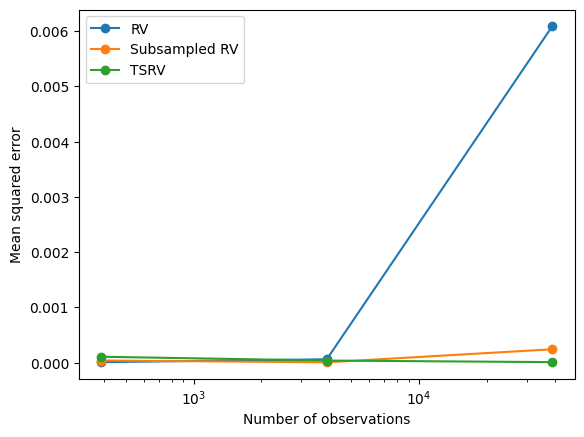

In [17]:
plt.figure()
for name, g in df_mc.groupby("estimator"):
    plt.plot(g["n"], g["mse"], marker="o", label=name)
plt.xlabel("Number of observations")
plt.ylabel("Mean squared error")
plt.legend()
plt.xscale("log")
plt.show()


In [18]:
plot_mse(df_mc, "figures/mse_vs_frequency.png")
print("Saved: figures/mse_vs_frequency.png")


Saved: figures/mse_vs_frequency.png


## Interpretation

- RV on observed prices becomes more biased as sampling frequency increases (signature plot).
- Subsampling reduces noise bias but increases variance.
- TSRV is more stable at high frequency and achieves the lowest MSE in this experiment.
